In [2]:
# import statements
import pandas as pd
from gurobipy import GRB, Model

# Aufgabe 1a) Visualisierung

Stromdaten PV Anlage


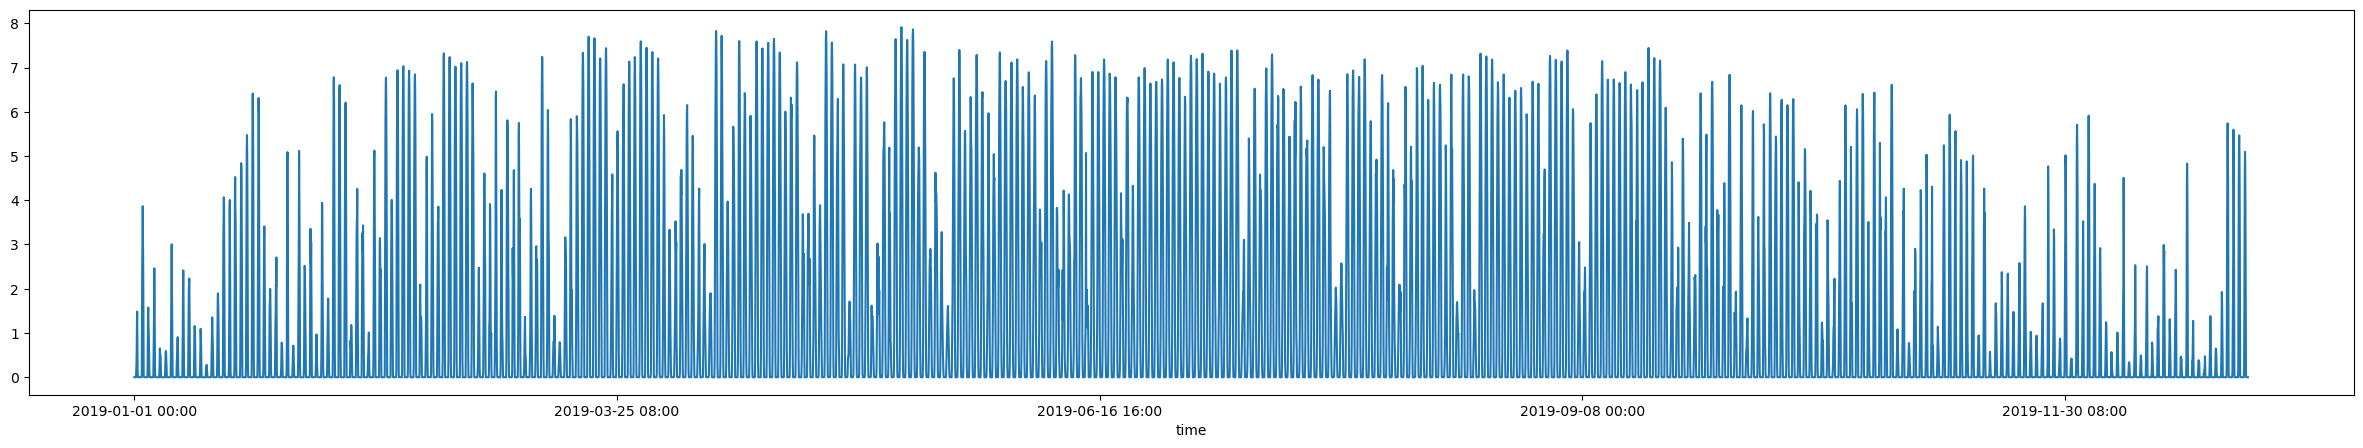

In [81]:
df = pd.read_csv("PV_Data.csv")
df.set_index("time", inplace = True)
df["electricity"].plot(figsize = (30,5))
print ("Stromdaten PV Anlage")

Winddaten


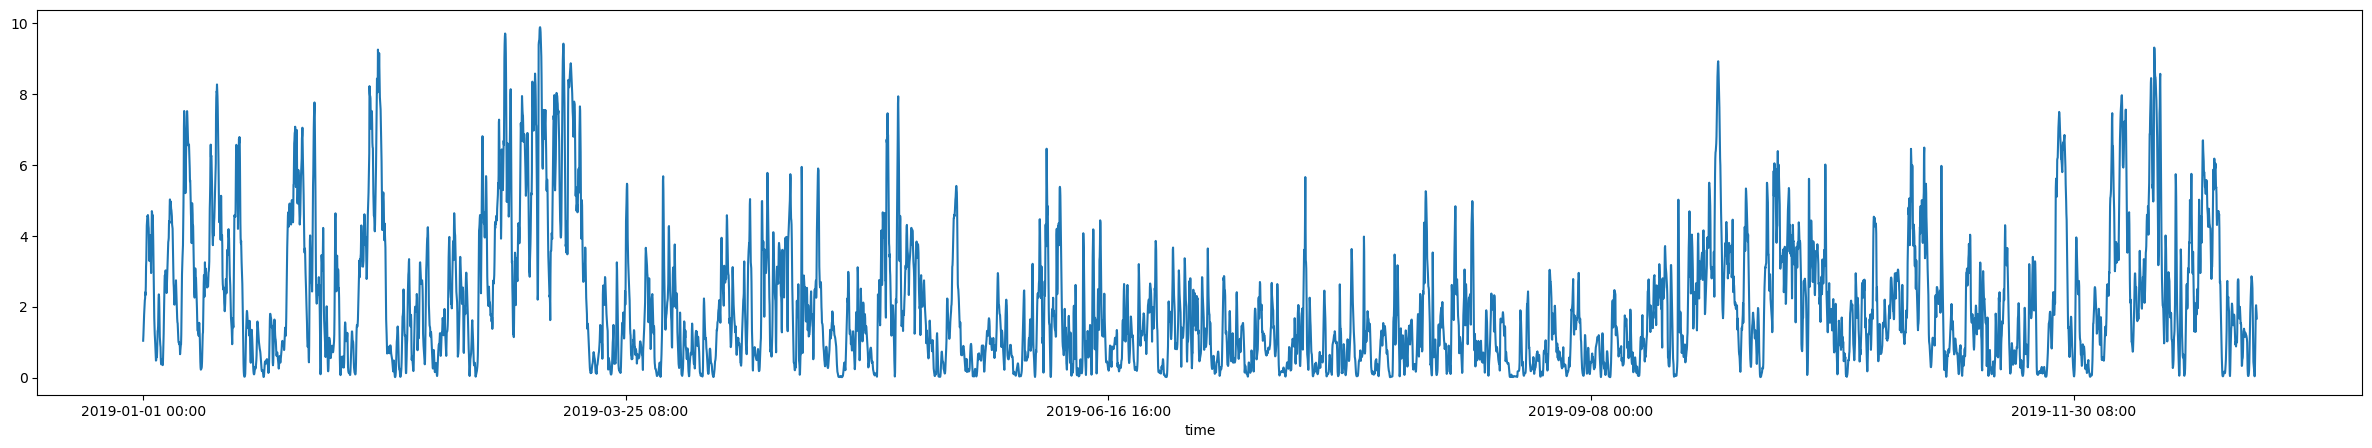

In [80]:
df = pd.read_csv("Wind_Data.csv")
df.set_index("time", inplace = True)
df["electricity"].plot(figsize = (30,5))
print ("Winddaten")

GroßhandelspreiseDE


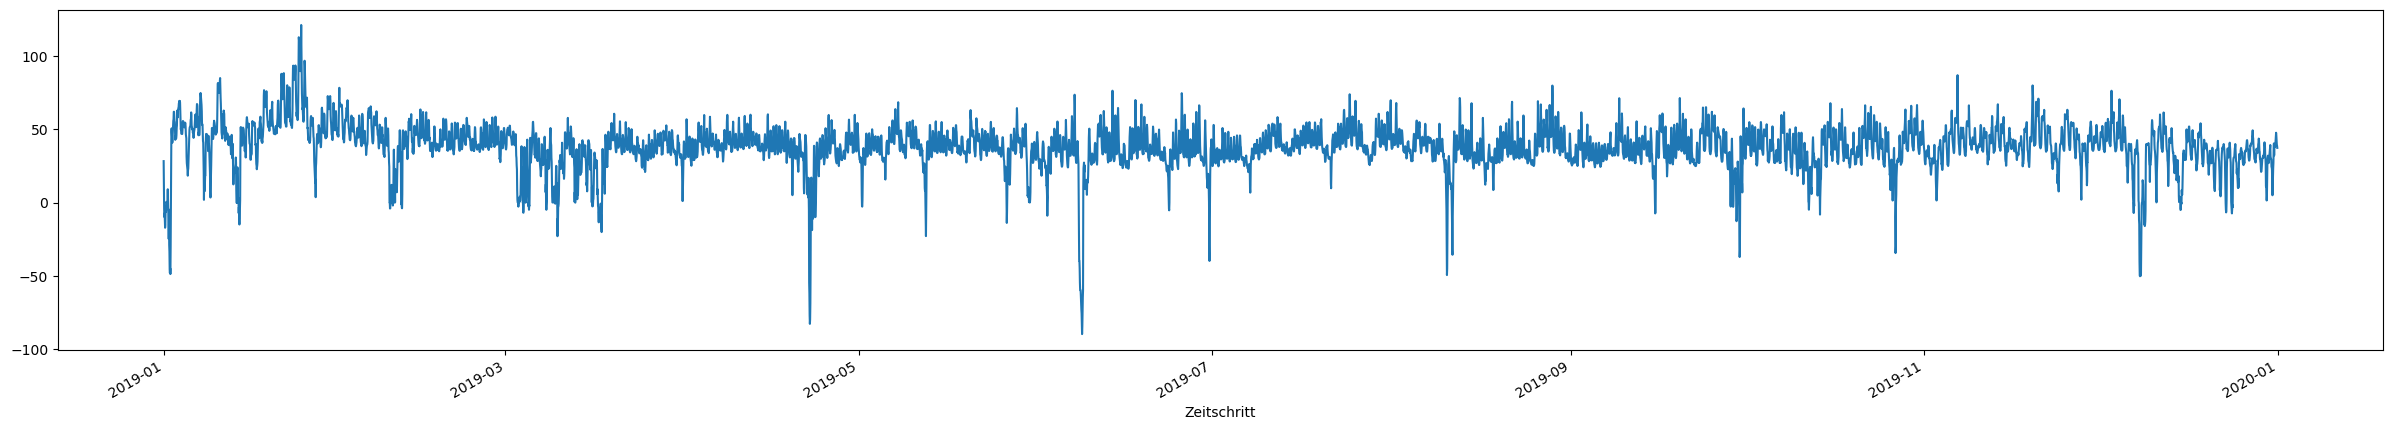

In [79]:
df = pd.read_csv("GroßhandelspreiseDE.csv", sep = ";", decimal = ",")
df["Zeitschritt"] = df.apply(lambda row: row["Datum"] + " " + row["Anfang"], axis = 1)
df["Zeitschritt"] = pd.to_datetime(df["Zeitschritt"], format ="%d.%m.%Y %H:%M")
df.set_index("Zeitschritt", inplace = True)
df["Deutschland/Luxemburg [€/MWh]"] = df["Deutschland/Luxemburg [€/MWh]"].astype(float)
df["Deutschland/Luxemburg [€/MWh]"].plot(figsize = (30,5))
print ("GroßhandelspreiseDE")

# Aufgabe 1b) Gewinnkalkulation

In [82]:
dfPreise = pd.read_csv("GroßhandelspreiseDE.csv", sep = ";", decimal = ",")
dfPreise["Zeitschritt"] = dfPreise.apply(lambda row: row["Datum"] + " " + row["Anfang"], axis = 1)
dfPreise["Zeitschritt"] = pd.to_datetime(dfPreise["Zeitschritt"], format ="%d.%m.%Y %H:%M")
dfPreise.set_index("Zeitschritt", inplace = True)
dfPreise["Deutschland/Luxemburg [€/MWh]"] = dfPreise["Deutschland/Luxemburg [€/MWh]"].astype(float)

dfWind = pd.read_csv("Wind_Data.csv")
dfWind["time"] = pd.to_datetime(dfWind["time"], format ="%Y-%m-%d %H:%M")

dfBerechnungWind = pd.merge(dfPreise , dfWind, how = "left", left_on = "Zeitschritt", right_on = "time")
dfBerechnungWind["Windgewinn"] = dfBerechnung.apply(lambda row: row["Deutschland/Luxemburg [€/MWh]"] *  row["electricity"], axis = 1)
print (dfBerechnungWind["Windgewinn"].sum() / 1000)

dfPV = pd.read_csv("PV_Data.csv")
dfPV["time"] = pd.to_datetime(dfPV["time"], format ="%Y-%m-%d %H:%M")

dfBerechnung = pd.merge(dfPreise , dfPV, how = "left", left_on = "Zeitschritt", right_on = "time")
dfBerechnung["PVgewinn"] = dfBerechnung.apply(lambda row: row["Deutschland/Luxemburg [€/MWh]"] *  row["electricity"], axis = 1)
print (dfBerechnung["PVgewinn"].sum() / 1000)

592.53957563
452.03098741


# Aufgabe 1c) Optimierung

In [3]:
# import data
df_pv = pd.read_csv('ninja_pv_49.0069_8.4034_corrected.csv', skiprows=3)
df_wind = pd.read_csv('ninja_wind_49.0069_8.4034_corrected.csv', skiprows=3)
df_prices = pd.read_csv('Gro_handelspreise_201901010000_201912312359_Stunde.csv', sep=';', decimal=',')

pv_generation = df_pv['electricity']
wind_generation = df_wind['electricity']
energy_prices = (1/1000) * df_prices['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] # EUR / kWh

In [6]:
# given parameters
timesteps = range(365 * 24) # hours of 2019
storage_capacity = 15 # kWh
storage_power = 5 # kW

## (1) PV

In [7]:
# initialize model
pv_model = Model('PV profit maximization')

# define variables
stored_energy = pv_model.addVars([t for t in timesteps], lb=0)
energy_sold = pv_model.addVars([t for t in timesteps], lb=0)

# define constraints

# (1) storage is empty at the beginning
pv_model.addConstr(stored_energy[0] == 0)

# (2) storage capacity is limited
for t in timesteps:
    pv_model.addConstr(stored_energy[t] <= storage_capacity)
    
for t in timesteps[:-1]:
    # (3) power is limited
    pv_model.addConstr(stored_energy[t+1] <= stored_energy[t] + storage_power)
    pv_model.addConstr(stored_energy[t+1] >= stored_energy[t] - storage_power)
    
    # (4) the energy sold on the market is dependent on storage and generation
    pv_model.addConstr(energy_sold[t] == pv_generation[t] + stored_energy[t] - stored_energy[t+1])

# (5) In the last time step, the stored energy is sold (limited by power)
pv_model.addConstr(energy_sold[timesteps[-1]] <= pv_generation[timesteps[-1]] + storage_power)
pv_model.addConstr(energy_sold[timesteps[-1]] <= pv_generation[timesteps[-1]] + stored_energy[t])

# set objective function
revenue = sum([energy_sold[t] * energy_prices[t] for t in timesteps]) # EUR
pv_model.setObjective(revenue, GRB.MAXIMIZE)

# solve
pv_model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 35040 rows, 17520 columns and 70077 nonzeros
Model fingerprint: 0xc1195874
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+01]
Presolve removed 24703 rows and 3636 columns
Presolve time: 0.18s
Presolved: 10337 rows, 19047 columns, 38089 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.583e+04
 Factor NZ  : 1.292e+05 (roughly 13 MB of memory)
 Factor Ops : 1.957e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective              

In [8]:
df_result = pd.DataFrame()
df_result['electricity price'] = energy_prices
df_result['energy generated'] = pv_generation
df_result['energy sold'] = [v.X for v in energy_sold.values()]
df_result['energy stored'] = [v.X for v in stored_energy.values()]
df_result.head()

,electricity price,energy generated,energy sold,energy stored
0,0.02832,0.0,0.0,0.0
1,0.01007,0.0,0.0,0.0
2,-0.00408,0.0,0.0,0.0
3,-0.00991,0.0,0.0,0.0
4,-0.00741,0.0,0.0,0.0


## (2) Wind

In [9]:
# given parameters
timesteps = range(365 * 24) # hours of 2019
storage_capacity = 15 # kWh
power = 5 # kW
wind_generation = df_wind['electricity']
energy_prices = (1/1000) * df_prices['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] # EUR / kWh

# initialize model
wind_model = Model('Wind power profit maximization')

# define variables
stored_energy = wind_model.addVars([t for t in timesteps], lb=0)
energy_sold = wind_model.addVars([t for t in timesteps], lb=0)

# (1) storage is empty at the beginning
wind_model.addConstr(stored_energy[0] == 0)

# (2) storage capacity is limited
for t in timesteps:
    wind_model.addConstr(stored_energy[t] <= storage_capacity)
    
for t in timesteps[:-1]:
    # (3) power is limited
    wind_model.addConstr(stored_energy[t+1] <= stored_energy[t] + power)
    wind_model.addConstr(stored_energy[t+1] >= stored_energy[t] - power)
    
    # (4) the energy sold on the market is dependent on storage and generation
    wind_model.addConstr(energy_sold[t] == wind_generation[t] + stored_energy[t] - stored_energy[t+1])

# (5) In the last time step, the stored energy is sold (limited by power)
wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + power)
wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + stored_energy[t])

# set objective function
revenue = sum([energy_sold[t] * energy_prices[t] for t in timesteps]) # EUR
wind_model.setObjective(revenue, GRB.MAXIMIZE)

# solve
wind_model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 35040 rows, 17520 columns and 70077 nonzeros
Model fingerprint: 0x1e6602c3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 2e+01]
Presolve removed 17526 rows and 3 columns
Presolve time: 0.15s
Presolved: 17514 rows, 26272 columns, 52540 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 4.378e+04
 Factor NZ  : 2.189e+05 (roughly 20 MB of memory)
 Factor Ops : 3.318e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.

In [10]:
df_result = pd.DataFrame()
df_result['electricity price'] = energy_prices
df_result['energy generated'] = wind_generation
df_result['energy sold'] = [v.X for v in energy_sold.values()]
df_result['energy stored'] = [v.X for v in stored_energy.values()]
df_result.head(10)

,electricity price,energy generated,energy sold,energy stored
0,0.02832,1.038,1.038,0.000
1,0.01007,1.184,1.184,0.000
2,-0.00408,1.402,1.402,0.000
3,-0.00991,1.574,0.000,0.000
4,-0.00741,1.776,0.000,1.574
5,-0.01255,1.913,0.000,3.350
6,-0.01725,2.008,0.000,5.263
7,-0.01507,2.183,0.000,7.271
8,-0.00493,2.230,0.000,9.454
9,-0.00633,2.407,0.000,11.684


## (3) Summary

In [11]:
pd.DataFrame({'Revenue without storage': [sum(gen * energy_prices) for gen in [pv_generation, wind_generation]],
              'Max. revenue with storage': [model.ObjVal for model in [pv_model, wind_model]]}, index=['PV', 'Wind'])

,Revenue without storage,Max. revenue with storage
PV,441.984259,533.731984
Wind,590.212709,724.023545


## (4) Optimierung falls Zukauf und Speicherung von Marktstrom erlaubt

### PV

In [12]:
# initialize model
pv_model = Model('PV profit maximization')

# define variables
stored_energy = pv_model.addVars([t for t in timesteps], lb=0)
energy_sold = pv_model.addVars([t for t in timesteps], lb=-GRB.INFINITY)

# define constraints

# (1) storage is empty at the beginning
pv_model.addConstr(stored_energy[0] == 0)

# (2) storage capacity is limited
for t in timesteps:
    pv_model.addConstr(stored_energy[t] <= storage_capacity)
    
for t in timesteps[:-1]:
    # (3) power is limited
    pv_model.addConstr(stored_energy[t+1] <= stored_energy[t] + storage_power)
    pv_model.addConstr(stored_energy[t+1] >= stored_energy[t] - storage_power)
    
    # (4) the energy sold on the market is dependent on storage and generation
    pv_model.addConstr(energy_sold[t] == pv_generation[t] + stored_energy[t] - stored_energy[t+1])

# (5) In the last time step, the stored energy is sold (limited by power)
pv_model.addConstr(energy_sold[timesteps[-1]] <= pv_generation[timesteps[-1]] + storage_power)
pv_model.addConstr(energy_sold[timesteps[-1]] <= pv_generation[timesteps[-1]] + stored_energy[t])

# set objective function
revenue = sum([energy_sold[t] * energy_prices[t] for t in timesteps]) # EUR
pv_model.setObjective(revenue, GRB.MAXIMIZE)

# solve
pv_model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 35040 rows, 17520 columns and 70077 nonzeros
Model fingerprint: 0xdf5f1a9c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 2e+01]
Presolve removed 26281 rows and 8760 columns
Presolve time: 0.07s
Presolved: 8759 rows, 17517 columns, 26275 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.759e+03
 Factor NZ  : 1.444e+05 (roughly 12 MB of memory)
 Factor Ops : 3.038e+06 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.17 seconds (0.03 work units)
Barrier solve interrupted - model solved by another algorithm


Solv

### Wind

In [13]:
# given parameters
timesteps = range(365 * 24) # hours of 2019
storage_capacity = 15 # kWh
power = 5 # kW
wind_generation = df_wind['electricity']
energy_prices = (1/1000) * df_prices['Deutschland/Luxemburg [€/MWh] Originalauflösungen'] # EUR / kWh

# initialize model
wind_model = Model('Wind power profit maximization')

# define variables
stored_energy = wind_model.addVars([t for t in timesteps], lb=0)
energy_sold = wind_model.addVars([t for t in timesteps], lb=-GRB.INFINITY)

# (1) storage is empty at the beginning
wind_model.addConstr(stored_energy[0] == 0)

# (2) storage capacity is limited
for t in timesteps:
    wind_model.addConstr(stored_energy[t] <= storage_capacity)
    
for t in timesteps[:-1]:
    # (3) power is limited
    wind_model.addConstr(stored_energy[t+1] <= stored_energy[t] + power)
    wind_model.addConstr(stored_energy[t+1] >= stored_energy[t] - power)
    
    # (4) the energy sold on the market is dependent on storage and generation
    wind_model.addConstr(energy_sold[t] == wind_generation[t] + stored_energy[t] - stored_energy[t+1])

# (5) In the last time step, the stored energy is sold (limited by power)
wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + power)
wind_model.addConstr(energy_sold[timesteps[-1]] <= wind_generation[timesteps[-1]] + stored_energy[t])

# set objective function
revenue = sum([energy_sold[t] * energy_prices[t] for t in timesteps]) # EUR
wind_model.setObjective(revenue, GRB.MAXIMIZE)

# solve
wind_model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 35040 rows, 17520 columns and 70077 nonzeros
Model fingerprint: 0xf16db7d5
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 2e+01]
Presolve removed 26281 rows and 8760 columns
Presolve time: 0.09s
Presolved: 8759 rows, 17517 columns, 26275 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 8.759e+03
 Factor NZ  : 1.444e+05 (roughly 12 MB of memory)
 Factor Ops : 3.038e+06 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.18 seconds (0.03 work units)
Barrier solve interrupted - model solved by another algorithm


Solv

In [15]:
pd.DataFrame({'Revenue without storage': [sum(gen * energy_prices) for gen in [pv_generation, wind_generation]],
              'Max. revenue with storage and purchasing of electricity': [model.ObjVal for model in [pv_model, wind_model]]}, index=['PV', 'Wind'])

,Revenue without storage,Max. revenue with storage and purchasing of electricity
PV,441.984259,625.636309
Wind,590.212709,773.864759
